In [1]:
from fireworks.ic import ic_two_body as ic_two_body
from fireworks.ic import ic_random_uniform as ic_random_uniform

from fireworks.nbodylib import dynamics as dyn
from fireworks.nbodylib import integrators as intg


import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Tuple
import numpy.typing as npt
from fireworks.particles import Particles

import time
import multiprocessing
from multiprocessing import Pool
def acceleration_direct_vectorized(N_particles, pos, mass):
   
    dx = pos[:, 0].reshape(N_particles, 1) - pos[:, 0] #broadcasting of (N,) on (N,1) array, obtain distance along x in an (N,N) matrix
    dy = pos[:, 1].reshape(N_particles, 1) - pos[:, 1] 
    dz = pos[:, 2].reshape(N_particles, 1) - pos[:, 2] 
      
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    r[r==0]=1
    
    dpos = np.concatenate((dx, dy, dz)).reshape((3,N_particles,N_particles)) 


    acc = - (dpos/r**3 @ mass).T
    jerk= None
    pot = None

    return acc, jerk, pot

def parallel_acc(a,b):
   
    # Questo può essere così oppure rendo global direttamente particles...
    global pos
    global N_particles
    global mass
  
    N_subset = abs(b-a)

    # Select particles from a to b to parallelize computation
    # Need to rewrite the function in order to compute quantities of subset of particles wrt all the others
    dx = pos[a:b, 0,np.newaxis] - pos[:, 0] #broadcasting of (N,) on (N,1) array, obtain distance along x in an (N,N) matrix
    dy = pos[a:b, 1,np.newaxis] - pos[:, 1] 
    dz = pos[a:b, 2,np.newaxis] - pos[:, 2] 
      
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    r[r==0]=1
    # New dpos shape is (3,N_particles,3000) since 
    # 3 is the number of dimensions, 
    # N_subset is the number of particles in the subset and
    # N_particles is the number of total particles
    # dpos is the distance vector between each particle in the subset and all the others

    dpos = np.concatenate((dx, dy, dz)).reshape((3,N_subset,N_particles)) 
   
    acc = - (dpos/r**3 @ mass).T
    jerk= None
    pot = None

    return acc, jerk, pot


In [2]:
def parallel_integrator(a,b):

    global vel
    global pos 
    global tstep
    #global acc 
    # acceleration is needed only to update vel and pos, so it is not needed as a global variable
    # acc should be allocated in a memory specific to the process
    acc, _ , _ = parallel_acc(a,b) # chissà se funziona

    # Euler integration
    vel[a:b] = vel[a:b] + acc * tstep  # Update vel
    pos[a:b] = pos[a:b] + vel[a:b] * tstep  # Update pos

    # there's no need to update acceleretion in my opinion...

    # Return the updated particles, the acceleration, jerk (can be None), and potential (can be None)
    return pos[a:b], vel[a:b]

In [4]:
import os

import os

file_path = "comparison.pdf"
if os.path.exists(file_path):
    print("The file exists.")
else:
    print("The file does not exist.")


The file exists.


In [3]:
def parallel_evo():

    #### MULTIPROCESSING ####
    # define the number of processes
    N_CORES = multiprocessing.cpu_count() # in my case 4 cores

    # start a timer
    #start = time.time()
    
    # how does it know N_particles? Lol
    N_PROCESSES = min(N_CORES, N_particles)
    # create a pool of processes
    pool = Pool(N_PROCESSES)


    # submit multiple instances of the function full_evo 
    # - starmap_async: allows to run the processes with a (iterable) list of arguments
    # - map_async    : is a similar function, supporting a single argument

    if N_particles < N_PROCESSES:
        # 1 process per particle
        future_results = pool.starmap_async(parallel_integrator, 
                                    [(i, (i + 1)) for i in range(N_particles)])
    else:
        # divide in equal part the particles into N_PROCESSES
        future_results = pool.starmap_async(parallel_integrator, 
                                    [(i * N_particles // N_PROCESSES, (i + 1) * N_particles // N_PROCESSES) for i in range(N_PROCESSES)])



    # to get the results all processes must have been completed
    # the get() function is therefore _blocking_ (equivalent to join) 
    results = future_results.get()

    # close the pool
    # not sure but internet(aka chatGPT) says that it is better to close the pool
    pool.close()

    return results



In [4]:
particles = ic_random_uniform(1000, [0,3],[0,3],[0,3])
pos = particles.pos
vel = particles.vel
mass = particles.mass
N_particles = len(particles)
tstep = 0.01

print(particles)

Instance of the class Particles
Number of particles: 1000


In [1]:
for i in range(3):
    print(i)

0
1
2


In [6]:
total_evo_time = 1
tstep=0.01


positions_slow = []
for _ in range(int(total_evo_time/tstep)):

    acc = intg.integrator_euler(particles=particles, tstep=tstep, acceleration_estimator= dyn.acceleration_direct_vectorized,softening="Dehnen")
    positions_slow.append(particles.pos)




In [7]:
pos_slow = np.array(positions_slow)
pos_slow.shape

(100, 1000, 3)

In [21]:
pos_slow.shape

(100, 1000, 3)

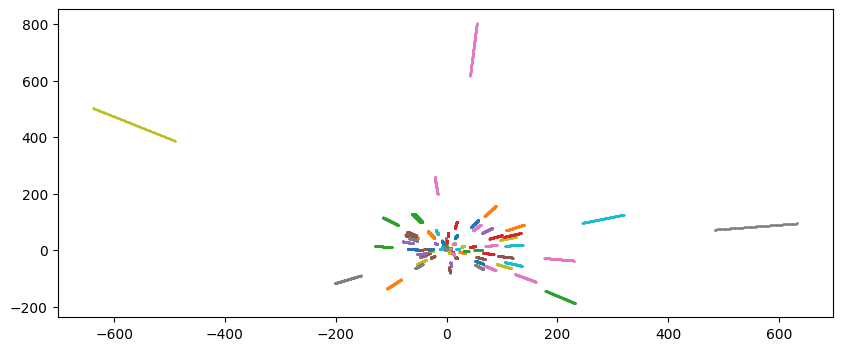

In [28]:
fig,ax = plt.subplots(figsize=(10,4))
# all iterations, particle 0, x and y
for i in range(pos_slow.shape[0]):
    ax.scatter(pos_slow[:,i,0],pos_slow[:,i,1],s=.5)


# Let's see if it works with the multiprocessing

In [2]:
particles = ic_two_body(1,1,1,0)
pos = particles.pos
vel = particles.vel
mass = particles.mass
N_particles = len(particles)
tstep = 0.01

print(particles)

Instance of the class Particles
Number of particles: 2


In [3]:
total_evo_time = 10
tstep=0.01

positions = []
for _ in range(int(total_evo_time/tstep)):
    print("pos before",particles.pos)
    #particles, tstep, acc, jerk, potential = intg.integrator_euler(particles=particles, tstep=tstep, acceleration_estimator= dyn.acceleration_direct_vectorized,softening="Dehnen")
    acc = intg.integrator_euler(particles=particles, tstep=tstep, acceleration_estimator= dyn.acceleration_direct,softening="Dehnen")
    #
    print("pos after",particles.pos)
    break
        



pos before [[0. 0. 0.]
 [1. 0. 0.]]
pos after [[ 1.00000000e-04 -7.07106781e-03  0.00000000e+00]
 [ 9.99900000e-01  7.07106781e-03  0.00000000e+00]]


In [ ]:
total_evo_time = 10
tstep=0.01

positions = []
for _ in range(int(total_evo_time/tstep)):

    start = time.time()
    results = parallel_evo()
    end_parallel = time.time()

    # update global variables directly
    pos = np.concatenate([results[i][0] for i in range(len(results))])
    vel = np.concatenate([results[i][1] for i in range(len(results))])
    end_concat = time.time()
    positions.append(pos)

    print(f"Parallel time: {end_parallel-start}")
    print(f"Concat time: {end_concat-end_parallel}")
    
        



In [ ]:
pos_array = np.array(positions)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(pos_array[:,0,0], pos_array[:,0,1],label="particle1")
plt.plot(pos_array[:,1,0], pos_array[:,1,1],label="particle2")
plt.legend()
plt.show()

In [ ]:
pos_array.shape

In [ ]:
pos_slow = np.array(positions_slow)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(pos_array[:,0,0], pos_array[:,0,1],label="particle1")
ax[0].plot(pos_array[:,1,0], pos_array[:,1,1],label="particle2")
ax[0].legend()
ax[0].set_title("Parallel")

ax[1].plot(pos_slow[:,0,0], pos_slow[:,0,1],label="particle1")
ax[1].plot(pos_slow[:,1,0], pos_slow[:,1,1],label="particle2")
ax[1].legend()
ax[1].set_title("Serial")

In [ ]:
fig.savefig("compa.pdf")